In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os,itertools
from scipy.interpolate import griddata
import pyslha
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def interpolateData(x,y,z,nx=200,ny=200,method='linear',fill_value=np.nan,xnew=None,ynew=None):

    if x.min() == x.max() or y.min() == y.max(): # Can not interpolate
        return None,None,None
    elif xnew is None or ynew is None:
        xnew = np.linspace(x.min(),x.max(),nx)
        ynew = np.linspace(y.min(),y.max(),ny)

    xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
    znew = griddata(list(zip(x,y)),z,xi=xi, 
                    method=method,fill_value=fill_value)
    znew = np.reshape(znew,(len(xnew),len(ynew)))
    xnew,ynew  = np.meshgrid(xnew,ynew,indexing='ij')

    return xnew,ynew,znew

In [3]:
# TRHadGM1

readSummary = True # whether to read SModelS results or load stored data

# Read SModelS summary
if readSummary:
    df = pd.read_csv('TRHadGM1_summary.txt',skiprows=3,sep='\\s+')
    condition = df['r_max'].notna()
    df = df[condition]

    
    # Add model data
    slha_dir = '/Users/altakach/SModelS3/smodels/run-dir-validation-ATLAS-SUSY-18-42-TRHadGM1/slha/'
    modelData = []
    for f in df['#filename']:
        data = pyslha.readSLHAFile(os.path.join(slha_dir,f))
        mGo = abs(data.blocks['MASS'][1000021])
        width_Go = data.decays[1000021].totalwidth
        modelData.append([mGo,width_Go])
    modelData = np.array(modelData)
    df[['mGo','wGo']] = modelData
    # Save to CSV
    df.to_csv('validation_data_TRHadGM1.csv')
else:
    # Read stored results
    df = pd.read_csv('validation_data_TRHadGM1.csv')


In [4]:
x,y = df['mGo'], 6.582e-25 / (df['wGo']*10**-9)
rValues = df['r_max']
nx = len(x)
ny = len(y)

xnew,ynew,znew = interpolateData(x,y,rValues,nx=nx,ny=ny,fill_value=0.0)

In [5]:
# Official curve
excATLAS = np.genfromtxt('../orig/Rhadrons_Obs_massLim_Short.csv',skip_header=1,delimiter=',')

# Convert the first column from GeV to nano seconds
excATLAS[:, 1] = 6.582e-25 / (excATLAS[:, 1] * 10**-9)
print(excATLAS)


[[2.0560e+03 6.5820e+04]
 [2.0560e+03 1.6455e+08]]


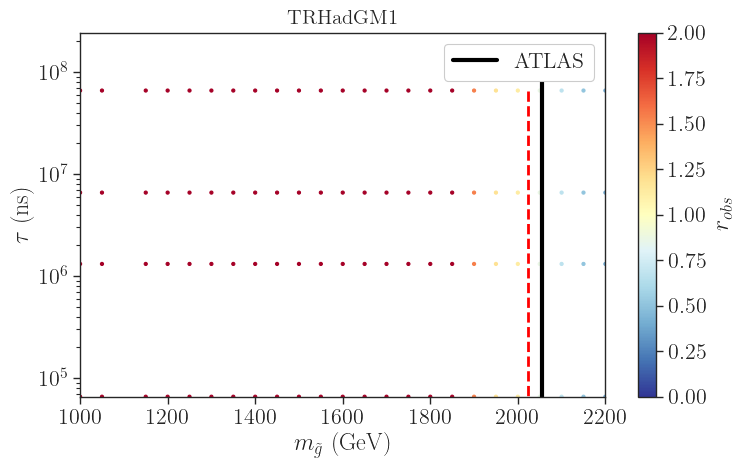

In [6]:
fig = plt.figure(figsize=(8,5))


plt.plot(excATLAS[:,0],excATLAS[:,1],label='ATLAS',linewidth=3,linestyle='-',color='black')
plt.contour(xnew, ynew, znew, [1.0], colors='red',linestyles=['dashed'],linewidths=2.0)
plt.scatter(x,y,c=rValues,s=5,cmap=plt.colormaps.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.yscale('log')

plt.title(r'TRHadGM1 ',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='upper right')
plt.colorbar(label=r'$r_{obs}$')
plt.savefig('TRHadGM1.png')
plt.show()